### Stereonet plots with the module mplstereonet

credits to: http://geologyandpython.com/structural_geology.html

In [1]:
import numpy as np
import pandas as pd # and of course Pandas
import matplotlib.pyplot as plt
import mplstereonet

In [2]:
def dir2cart(d):
    """
    Converts a list or array of vector directions in degrees (declination,
    inclination) to an array of the direction in cartesian coordinates (x,y,z)

    Parameters
    ----------
    d : list or array of [dec,inc] or [dec,inc,intensity]

    Returns
    -------
    cart : array of [x,y,z]

    Examples
    --------
    >>> pmag.dir2cart([200,40,1])
    array([-0.71984631, -0.26200263,  0.64278761])
    """
    ints = np.ones(len(d)).transpose(
    )  # get an array of ones to plug into dec,inc pairs
    d = np.array(d)
    rad = np.pi/180.
    if len(d.shape) > 1:  # array of vectors
        decs, incs = d[:, 0] * rad, d[:, 1] * rad
        if d.shape[1] == 3:
            ints = d[:, 2]  # take the given lengths
    else:  # single vector
        decs, incs = np.array(float(d[0])) * rad, np.array(float(d[1])) * rad
        if len(d) == 3:
            ints = np.array(d[2])
        else:
            ints = np.array([1.])
    cart = np.array([ints * np.cos(decs) * np.cos(incs), ints *
                     np.sin(decs) * np.cos(incs), ints * np.sin(incs)]).transpose()
    return cart

In [3]:
def cart2dir(cart):
    """
    Converts a direction in cartesian coordinates into declination, inclinations

    Parameters
    ----------
    cart : input list of [x,y,z] or list of lists [[x1,y1,z1],[x2,y2,z2]...]

    Returns
    -------
    direction_array : returns an array of [declination, inclination, intensity]

    Examples
    --------
    >>> pmag.cart2dir([0,1,0])
    array([ 90.,   0.,   1.])
    """
    cart = np.array(cart)
    rad = np.pi / 180.  # constant to convert degrees to radians
    if len(cart.shape) > 1:
        Xs, Ys, Zs = cart[:, 0], cart[:, 1], cart[:, 2]
    else:  # single vector
        Xs, Ys, Zs = cart[0], cart[1], cart[2]
    if np.iscomplexobj(Xs):
        Xs = Xs.real
    if np.iscomplexobj(Ys):
        Ys = Ys.real
    if np.iscomplexobj(Zs):
        Zs = Zs.real
    Rs = np.sqrt(Xs**2 + Ys**2 + Zs**2)  # calculate resultant vector length
    # calculate declination taking care of correct quadrants (arctan2) and
    # making modulo 360.
    Decs = (np.arctan2(Ys, Xs) / rad) % 360.
    try:
        # calculate inclination (converting to degrees) #
        Incs = np.arcsin(Zs/Rs) /rad
    except:
        print('trouble in cart2dir')  # most likely division by zero somewhere
        return np.zeros(3)

    return np.array([Decs, Incs, Rs]).transpose()  # return the directions list

#### Input

In [4]:
#Collecting the data: bedding planes
df = pd.DataFrame(columns = ('So_dipdir','So_dip'))
#df['So_strike'] = [114,107,108,100,105,102,95,90,83,75,76] #dip sense to the NE
df['So_dipdir'] = [360,350]  
df['So_dip'] = [45,40]
df

,So_dipdir,So_dip
0,360,45
1,350,40


#### Method to calculate mean plane:
1. Calculate bedding poles
2. Convert poles to XYZ coordinates with function dir2cart().
3. Calculate mean pole by sum of all X, Y, and Z components.
4. Convert mean pole from XYZ to polar coordinates with function cart2dir().


In [5]:
#Calculate bedding poles
ones = np.full((len(df), 1), int(1)).T
bedding_poles = np.append(np.array([df['So_dipdir']-180]), 90 - np.array([df['So_dip']]), axis =0)
bedding_poles = np.append(bedding_poles, ones, axis =0).T  #Calculate the mean bedding pole


In [6]:
cartesian_coord = dir2cart(bedding_poles)
cartesian_coord.round(4)

array([[-0.7071,  0.    ,  0.7071],
       [-0.633 ,  0.1116,  0.766 ]])

In [7]:
df['poleX'],df['poleY'],df['poleZ'] = cartesian_coord[:,0],cartesian_coord[:,1],cartesian_coord[:,2]
df.round(4)

,So_dipdir,So_dip,poleX,poleY,poleZ
0,360,45,-0.7071,0.0000,0.7071
1,350,40,-0.6330,0.1116,0.7660


In [8]:
#Calculate the mean bedding pole
mean_pole_cart = np.array([df['poleX'].sum(),df['poleY'].sum(),df['poleZ'].sum()])
mean_bedding_pole_2 = cart2dir(mean_pole_cart).round(1)

#Calculate the mean bedding plane
mean_bedding_2 = np.array([mean_bedding_pole_2[0]-180,90-mean_bedding_pole_2[1]]).round(1)
if mean_bedding_pole_2[0] < 180:
    mean_bedding_2 = np.array([mean_bedding_pole_2[0]+180,90-mean_bedding_pole_2[1]]).round(1)
else:
    pass

#Calculate standard deviation
mean_pole_cart/=np.linalg.norm(mean_pole_cart) #mean pole unit vector
sumatori = 0
for n in range(len(df)):
    m = (2*np.arcsin(np.sqrt((df['poleX'][n]-mean_pole_cart[0])**2+
                       (df['poleY'][n]-mean_pole_cart[1])**2+
                       (df['poleZ'][n]-mean_pole_cart[2])**2)/2))**2
    sumatori += m
stdev = np.degrees(np.sqrt(sumatori/(len(df)))).round(1)

print('The mean bedding pole (azimuth/dip) is {0} / {1}'.format(mean_bedding_pole_2[0],mean_bedding_pole_2[1]))
print('The mean bedding orientation (dipdir/dip) is {0} / {1}'.format(mean_bedding_2[0],mean_bedding_2[1]))
print('The standard deviantion (in degrees) is {0}'.format(stdev))

The mean bedding pole (azimuth/dip) is 175.2 / 47.6
The mean bedding orientation (dipdir/dip) is 355.2 / 42.4
The standard deviantion (in degrees) is 4.2


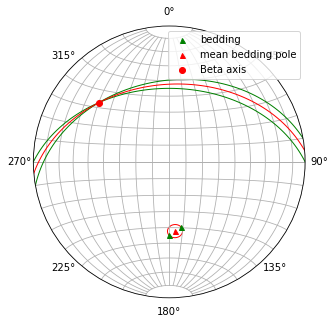

In [9]:
strike = list(df['So_dipdir']-90)
dip = list(df['So_dip'])
mean_strike, mean_dip = mean_bedding_2[0]-90, mean_bedding_2[1]
mean_pole_bearing, mean_pole_plunge = mean_bedding_pole_2[0],mean_bedding_pole_2[1]

girdle_strike, girdle_dip = mplstereonet.fit_girdle(strike, dip)



fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='stereonet')
ax.plane(strike, dip, 'g-', linewidth=1)
ax.plane(mean_strike,mean_dip,'r-',linewidth=1)
ax.cone(mean_pole_plunge,mean_pole_bearing,stdev,color='red', facecolor='none') #plunge, bearing, angle(radius) of semicone
ax.pole(strike, dip, 'g^', markersize=5, label ='bedding')
ax.pole(mean_strike,mean_dip, 'r^', markersize=5, label='mean bedding pole')
ax.pole(girdle_strike, girdle_dip, c='r', label='Beta axis')

#ax.rake(strike, dip, -25)
#ax.line(30,10)
ax.grid()
ax.legend()
plt.show()